In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [106]:
common_props_path = 'commonProps.csv'
common_props_raw: pd.DataFrame = pd.read_csv(common_props_path)
common_props_raw

,runNumber,timePoint,diskLoad,ioChannelLoad,processorsLoad,totalWaitAllocate,useOfPage
0,0,3.000000,0.000000,0.000000,0.000000,0.0,0.0
1,0,3.000000,0.000000,0.000000,0.000000,0.0,58.0
2,0,3.000000,0.000000,0.000000,4.918975,0.0,58.0
3,0,5.042720,0.000000,0.000000,2.926382,0.0,58.0
4,0,9.215264,0.000000,0.000000,1.601357,0.0,58.0
...,...,...,...,...,...,...,...
2370288,3,399996.092150,0.005368,0.002141,1.429980,0.0,40.0
2370289,3,399998.000000,0.005368,0.002141,1.429973,0.0,40.0
2370290,3,399998.000000,0.005368,0.002141,1.429973,0.0,96.0
2370291,3,399998.000000,0.005368,0.002141,1.429990,0.0,96.0


In [107]:
common_props_raw.dtypes

runNumber              int64
timePoint            float64
diskLoad             float64
ioChannelLoad        float64
processorsLoad       float64
totalWaitAllocate    float64
useOfPage            float64
dtype: object

In [108]:
time_in_system_file_path = 'timeInSystem.csv'
time_in_system_raw: pd.DataFrame = pd.read_csv(time_in_system_file_path)
time_in_system_raw

,runNumber,timePoint,timeInSystem
0,0,14.388110,4.388110
1,0,17.815221,14.815221
2,0,22.200705,6.200705
3,0,29.437687,8.437687
4,0,37.674123,8.674123
...,...,...,...
228808,3,399951.853032,8.853032
228809,3,399955.134196,6.134196
228810,3,399978.848136,6.848136
228811,3,399979.523648,16.523648


In [109]:
time_in_system_raw.dtypes

runNumber         int64
timePoint       float64
timeInSystem    float64
dtype: object

In [110]:
time_wait_allocate_file_path = 'timeWaitAllocate.csv'
time_wait_allocate_raw: pd.DataFrame = pd.read_csv(time_wait_allocate_file_path, header=0)
time_wait_allocate_raw

,runNumber,timePoint,timeWaitAllocate
0,0,81.318693,2.318693
1,0,347.054666,2.054666
2,0,354.186224,2.186224
3,0,381.717378,2.717378
4,0,1049.441759,5.441759
...,...,...,...
6417,3,399578.718021,3.718021
6418,3,399618.996488,0.996488
6419,3,399620.579699,11.579699
6420,3,399650.941269,4.941269


In [111]:
time_wait_allocate_raw.dtypes

runNumber             int64
timePoint           float64
timeWaitAllocate    float64
dtype: object

In [112]:
import numpy as np
from array import array
from typing import Sequence


def calculate_means_through_time(time_points: pd.Series, values: pd.Series) -> array[float]:
    prev_time_point = time_points.iloc[0]
    delay_sum = 0.0
    value_sum = 0.0

    values_through_time = array('d')

    for time_point, value in zip(time_points.iloc[1:], values):
        delay = time_point - prev_time_point
        prev_time_point = time_point
        delay_sum += delay
        value_sum += value * delay
        values_through_time.append(value_sum / delay_sum)

    return values_through_time

def calculate_stddevs_through_time(time_points: pd.Series, values: pd.Series, means: array[float]) -> array[float]:
    prev_time_point = time_points.iloc[0]
    delay_sum = 0.0
    value_sum = 0.0

    stddevs_through_time: array[float] = array('d')

    for time_point, value, mean in zip(time_points.iloc[1:], values, means):
        delay = time_point - prev_time_point
        prev_time_point = time_point
        delay_sum += delay
        value_sum += ((value - mean) ** 2) * delay
        stddevs_through_time.append(np.sqrt(value_sum / delay_sum))

    return stddevs_through_time

In [113]:
import attr

@attr.frozen
class PropertyMeanStdDev:
    mean: array[float]
    stdDev: array[float]

def calc_mean_stddev_through_time(time_points: pd.Series, props: pd.Series) -> PropertyMeanStdDev:
    means = calculate_means_through_time(time_points, props)
    return PropertyMeanStdDev(
        means,
        calculate_stddevs_through_time(time_points, props, means)
    )

In [114]:
from collections import deque

time_points_mat: deque[Sequence[float]] = deque()
disk_load_mat: deque[PropertyMeanStdDev] = deque()
io_channel_load_mat: deque[PropertyMeanStdDev] = deque()
processors_load_mat: deque[PropertyMeanStdDev] = deque()
use_of_page_mat: deque[PropertyMeanStdDev] = deque()
total_wait_allocate_mat: deque[PropertyMeanStdDev] = deque()

time_in_system_mat: deque[PropertyMeanStdDev] = deque()
time_wait_allocate_mat: deque[PropertyMeanStdDev] = deque()
time_in_system_time_points_mat: deque[PropertyMeanStdDev] = deque()
time_wait_allocate_time_points_mat: deque[PropertyMeanStdDev] = deque()

In [115]:
total_runs_num = len(common_props_raw['runNumber'].value_counts())
total_runs_num

4

In [116]:
for run_number in range(total_runs_num):
    common_props_raw_indexed = common_props_raw[common_props_raw['runNumber'] == run_number]
    time_points = common_props_raw_indexed['timePoint'][:-1]
    disk_load_mat.append(calc_mean_stddev_through_time(time_points, common_props_raw_indexed['diskLoad']))
    io_channel_load_mat.append(calc_mean_stddev_through_time(time_points, common_props_raw_indexed['ioChannelLoad']))
    processors_load_mat.append(calc_mean_stddev_through_time(time_points, common_props_raw_indexed['processorsLoad']))
    use_of_page_mat.append(calc_mean_stddev_through_time(time_points, common_props_raw_indexed['useOfPage']))
    total_wait_allocate_mat.append(calc_mean_stddev_through_time(time_points, common_props_raw_indexed['totalWaitAllocate']))
    time_points_mat.append(time_points[:-1])

    time_in_system_raw_indexed = time_in_system_raw[time_in_system_raw['runNumber'] == run_number]
    time_in_system_time_points = time_in_system_raw_indexed['timePoint']
    time_in_system_mat.append(calc_mean_stddev_through_time(time_in_system_time_points, time_in_system_raw_indexed['timeInSystem']))
    time_in_system_time_points_mat.append(time_in_system_time_points.iloc[:-1])

    time_wait_allocate_raw_indexed = time_wait_allocate_raw[time_wait_allocate_raw['runNumber'] == run_number]
    time_wait_allocate_time_points = time_wait_allocate_raw_indexed['timePoint']
    time_wait_allocate_mat.append(calc_mean_stddev_through_time(time_wait_allocate_time_points, time_wait_allocate_raw_indexed['timeWaitAllocate']))
    time_wait_allocate_time_points_mat.append(time_wait_allocate_time_points.iloc[:-1])

/tmp/ipykernel_83473/689705320.py:18: RuntimeWarning: invalid value encountered in scalar divide
  values_through_time.append(value_sum / delay_sum)
/tmp/ipykernel_83473/2703673564.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  time_points = common_props_raw_indexed['timePoint'][:-1]
/tmp/ipykernel_83473/2703673564.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  time_points_mat.append(time_points[:-1])


In [117]:
from typing import Iterable

def plot_matrix(time_points_mat: Iterable[float], value_mat: Iterable[float], ylabel: str):
    for run_num, row in enumerate(zip(time_points_mat, value_mat)):
        time_points_row = row[0]
        value_row = row[1]
        plt.plot(time_points_row, value_row, label=f'Run {run_num}')

    plt.title(f'{ylabel} vs. TimePoint for Each Run')
    plt.xlabel('TimePoint')
    plt.ylabel(ylabel)
    plt.legend(title='Run Number')
    plt.grid(True)
    plt.show()

def plot_matrix_mean_std_dev(time_points_mat: Sequence[float], value_mat: deque[PropertyMeanStdDev], ylabel: str):
    plot_matrix(time_points_mat, (v.mean for v in value_mat), ylabel + 'Mean')
    plot_matrix(time_points_mat, (v.stdDev for v in value_mat), ylabel + 'StdDev')

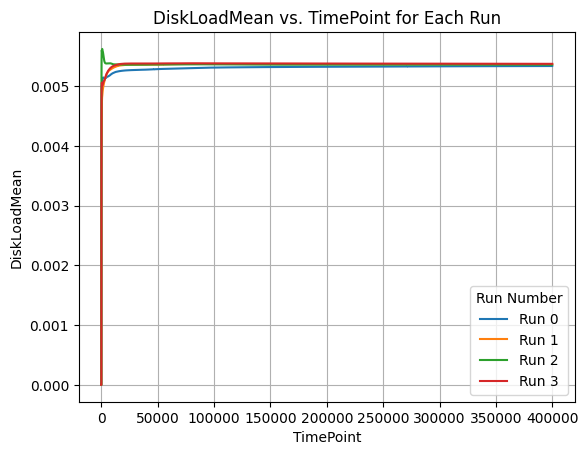

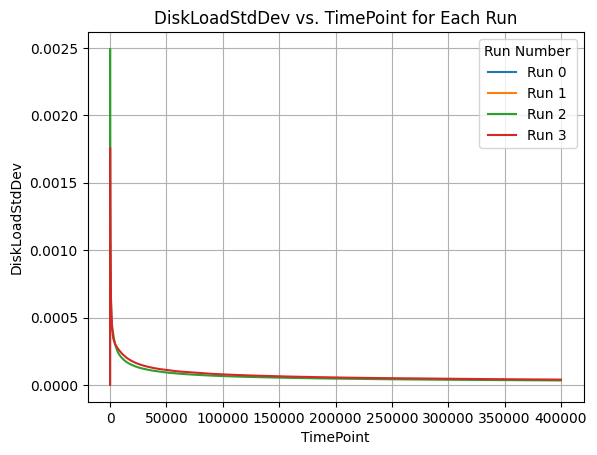

In [119]:
plot_matrix_mean_std_dev(time_points_mat, disk_load_mat, 'DiskLoad')

In [58]:
transit_period_start_at = 600000

In [ ]:
filtered_data = data[data['timePoint'] > transit_period_start_at]

In [112]:
def show_hist(data, col_name: str) -> None:
    plt.figure(figsize=(10, 6))
    plt.hist(data[col_name], bins=50, edgecolor='k', alpha=0.7)
    plt.title(f'Histogram of {col_name}')
    plt.xlabel(col_name)
    plt.ylabel('Frequency')
    plt.grid(True)

In [ ]:
show_hist(filtered_data, 'diskLoad')

In [ ]:
show_hist(filtered_data, 'ioChannelLoad')

In [ ]:
show_hist(filtered_data, 'processorsLoad')

In [ ]:
show_hist(filtered_data, 'totalWaitAllocate')

In [ ]:
show_hist(filtered_data, 'useOfPage')

In [119]:
time_in_system_data = time_in_system_raw[time_in_system_raw['timePoint'] > transit_period_start_at]

In [ ]:
show_hist(time_in_system_data, 'timeInSystem')

In [122]:
wait_allocate_data = wait_allocate_raw[wait_allocate_raw['timePoint'] > transit_period_start_at]

In [ ]:
show_hist(wait_allocate_data, 'timeWaitAllocate')